In [2]:
import xml.dom.minidom
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pylab as plt
import pandas as pd
import json
import os
import pickle
import math

In [3]:
def tokenExtractor(file):
    data = open(file, encoding="utf-8").read()

    doc = xml.dom.minidom.parse(file)

    movieText = ""

    for item in doc.getElementsByTagName("s"):
        for child in item.childNodes:
            if child.nodeName == "#text" and len(re.findall("\w", child.nodeValue)) > 1:
                movieText += child.nodeValue

    movieText = re.sub("\n\s+", " ", movieText)
    movieText = re.sub("\n", "", movieText)

    pattern = r'''(?x)(?:[A-Z]\.)+ | \w+(?:-\w+)*  | '''
    tokens = nltk.regexp_tokenize(movieText, pattern)

    #Remove non alphanumericbetic characters
    tokens = [w for w in tokens if re.search(r'\w', w)]

    #Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if w.lower() not in stopwords]

    #Remove numbers 
    tokens = [w for w in tokens if not re.search(r'\d', w)]

    #Lower case
    tokens = [t.lower() for t in tokens]
    tokens = [item for item in tokens if item.isalpha()]
    
    return tokens

In [4]:
def has_genre(genre, movie_data):
    genres_data = movie_data["genres"].replace("'", '"')
    genres_json = json.loads(genres_data)
    for g_object in genres_json:
        if g_object["name"] == genre:
            return True
    return False

In [5]:
def loadData():
    metadata_file = "movies_metadata.csv"
    genre_set = {""}

    metadata_data = pd.read_csv(metadata_file, encoding ='utf-8')
    for genre_list in metadata_data["genres"]:
        genre_list = genre_list.replace("'", '"')
        genre_json = json.loads(genre_list)
        for genre in genre_json:
            genre_set.add(genre["name"])
    
    return genre_set, metadata_data

In [13]:
def generateTokensFor(choosen_genre, metadata_data):
    tokens = []

    for index, movie in metadata_data.iterrows():
        if has_genre(choosen_genre, movie):
            if len(str(movie["release_date"]).split("-")[0]) == 4:
                release_date = movie["release_date"].split("-")[0]
                
            movie_id = str(movie["imdb_id"])

            if len(movie_id) > 1:
                while movie_id[0] == 't' or movie_id[0] == '0' :
                    movie_id = movie_id[1:]

            movieDir = "/Subs/en/{}/{}".format(release_date, movie_id)

            try:
                files = os.listdir(movieDir)
                movie_file = movieDir + '/' + files[0]

                tokens = tokens + tokenExtractor(movie_file)
            except:
                # print("Cannot find file " + movieDir)
                pass
                
    return tokens

Loading error list
Science Fiction
Mystery
Animation
Foreign
History
Horror
Drama
Crime
Action
Filmworks


Total genres
{'',
 'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}
 
Loaded genres
Romance
Foreign
TV Movie
Music
Fantasy
History
Crime
Animation

TODO
{'',
 'Action',
 'Adventure',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Documentary',
 'Drama',
 'Family',
 'GoHands',
 'Horror',
 'Mardock Scramble Production Committee',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Science Fiction',
 'Sentai Filmworks',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}
 
Processed

Horror
Foreign
Music

In [8]:
genres, data = loadData()

In [10]:
genres.remove("")
genres.remove("Horror")
genres.remove("Foreign")
genres.remove("Music")
genres

{'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'GoHands',
 'History',
 'Mardock Scramble Production Committee',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}

In [ ]:
genres_tokens = {}

genres_tokens["Action"] = generateTokensFor("Action", data)
print("done Action")
genres_tokens["Adventure"] = generateTokensFor("Adventure", data)
print("done Adventure")
genres_tokens["Animation"] = generateTokensFor("Animation", data)
print("done Animation")
genres_tokens["Aniplex"] = generateTokensFor("Aniplex", data)
print("done Aniplex")
genres_tokens["BROSTA TV"] = generateTokensFor("BROSTA TV", data)
print("done BROSTA TV")

In [204]:
pickle_file = open("genres_tokens_action-adventure-animation-aniplex-brosta tv.backup", "wb")

pickle.dump(genres_tokens, pickle_file)

pickle_file.close()

In [190]:
#nbWords is a dict of the number of iteration of each word, for example [{"hello", 3}, {"going", 1}]
#tokens is a list of all the words

def computeTF(nbWords, tokens):
    tfDict = {}
    tokenCount = len(tokens)
    for word, count in nbWords.items():
        tfDict[word] = count / float(tokenCount)
    
    return tfDict

In [191]:
#documents is an array of every dict used as nbWords parameter for the computeTF function

def computeIDF(documents):
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    
    for document in documents:
        for word, val in document.items():
            if val > 0:
                if word in idfDict:
                    idfDict[word] += 1
                else:
                    idfDict[word] = 1
                
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
        
    return idfDict

In [192]:
def getNbUniqueWord(word_list):
    nb_word = {}
    for word in word_list:
        if word in nb_word:
            nb_word[word] += 1
        else:
            nb_word[word] = 1
    
    return nb_word

In [193]:
uniqueWords = set()

genres_nb_word = {}

for genre in genres_tokens:
    uniqueWords = uniqueWords.union(set(genres_tokens[genre]))
    
    genres_nb_word[genre] = getNbUniqueWord(genres_tokens[genre])

genres_tfs = {}

for genre in genres_tokens:
    
    genres_tfs[genre] = computeTF(genres_nb_word[genre], genres_tokens[genre])
    
nb_word_array = []

for genre in genres_nb_word:
    nb_word_array.append(genres_nb_word[genre])

idfs = computeIDF(nb_word_array)

genres_tfidfs = {}

for genre in genres_tokens:
    tfidf = {}
    
    for word in genres_tfs[genre]:
        tfidf[word] = genres_tfs[genre][word] * idfs[word]
    
    genres_tfidfs[genre] = tfidf

In [195]:
#SAVE TFIDFs WITH PICKLE

In [186]:
wordclouds = {}

for genre in genres_tfidfs:
    wordclouds[genre] = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(genres_tfidfs[genre])

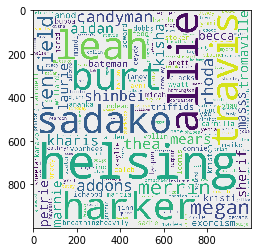

In [187]:
plt.imshow(wordclouds["Horror"])

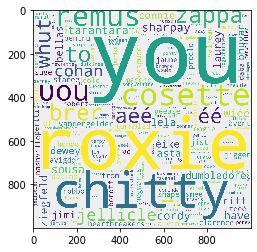

In [188]:
plt.imshow(wordclouds["Music"])

{'april': 688,
 'italian': 823,
 'troops': 474,
 'disembark': 5,
 'side': 6307,
 'adriatic': 3,
 'political': 624,
 'union': 618,
 'italy': 552,
 'albania': 32,
 'made': 17307,
 'name': 21476,
 'fascism': 37,
 'history': 2349,
 'days': 11407,
 'significant': 149,
 'albanian': 29,
 'assembly': 156,
 'decides': 237,
 'offer': 2082,
 'king': 4120,
 'crown': 520,
 'government': 1874,
 'sanction': 21,
 'new': 21696,
 'title': 547,
 'fascist': 111,
 'council': 426,
 'approve': 305,
 'albanese': 1,
 'party': 7596,
 'founded': 130,
 'tirana': 6,
 'aibanese': 1,
 'armies': 106,
 'armed': 509,
 'forces': 689,
 'joint': 669,
 'initiatives': 13,
 'follow': 4897,
 'courts': 114,
 'organised': 60,
 'schools': 320,
 'hospitals': 193,
 'rural': 63,
 'health': 1300,
 'centres': 26,
 'created': 1233,
 'help': 38204,
 'peasants': 168,
 'fight': 6384,
 'malaria': 49,
 'roads': 448,
 'housing': 142,
 'last': 22702,
 'thanks': 16863,
 'among': 1480,
 'robust': 28,
 'albanians': 12,
 'civilization': 247,
 't